# Hennepin Tracts Geo Info
This part of the repository demonstrates how we obtain the geograghical information of the tracts in Hennepin County. There are mainly three parts in this notebook:
1. We obtain the tracts geometries data from the Census API;
2. We try to map the tracts to the cities so that we can more levels of granularity for later analysis and visualizations
;
3. Since the tracts don't have real names, we try to name them (and rename some cities) by neighborhood names from the Bing Maps API to make it easier for users to refer to the areas;

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely
from glob import glob
import urllib
import json
import os
from zipfile import ZipFile
from matplotlib import pyplot as plt

## 1. Obtain Tracts Geometries Data
The data is available on the [Tiger API](https://www2.census.gov/geo/tiger/) on cencus.gov.

### Downloading
We will need the geometry data for both tracts and cities (places).

You can skip this section and use the files provided in the repository instead, if you don't feel like to download it yourself or the website is not available in your area.

In [2]:
# Dowloading the files...
if not os.path.exists('Download'):
    os.makedirs('Download') 
url = 'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_27_tract.zip'
download = 'Download/tl_2019_27_tract.zip'
if not os.path.exists(download):
    urllib.request.urlretrieve(url, download)

url = 'https://www2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_27_place.zip'
download = 'Download/tl_2019_27_place.zip'
if not os.path.exists(download):
    urllib.request.urlretrieve(url, download)

In [3]:
# Extracting the files...
zipfiles = glob('Download/tl_*.zip')

for file in zipfiles:
    folder = file.split('.')[0]
    if not os.path.exists(folder):
        os.makedirs(folder)
    with ZipFile(file, 'r') as z:
        z.extractall(folder)

## 2. Mapping Tracts to Cities
### Reading and ouputing tract geometries

In [4]:
geo = gp.read_file('Download/tl_2019_27_tract/tl_2019_27_tract.shp')
# Hennepin County Code is 053; 
# We excluded Tract 980000 because it's the MSP Airport and doesn't belong to any city.
geo = geo[(geo['COUNTYFP']=='053') & (geo['TRACTCE']!='980000')]

(-93.7964878, -93.1653342, 44.76223725, 45.26968374999999)

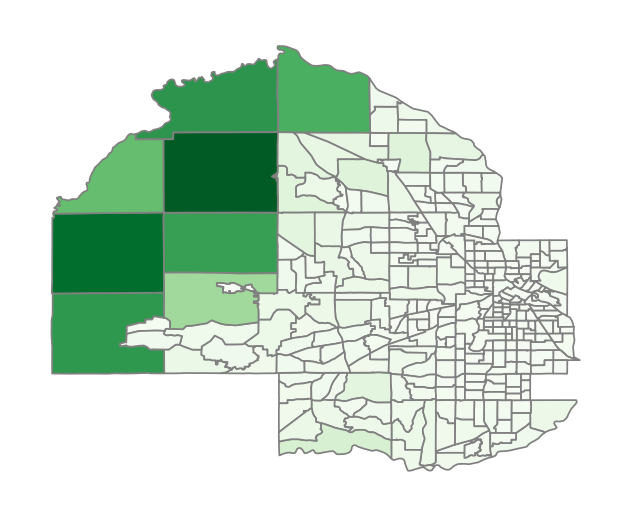

In [5]:
# Visualizing the tract map by area of land
f, ax = plt.subplots(1, dpi=250, figsize=(3, 3))
geo.plot('ALAND', ax=ax, vmin=0, vmax=10e7, cmap='Greens', linewidth=0.5,edgecolor='grey')
plt.axis(False)

In [6]:
# Outputing the tract geometries into geojsons
geo[['TRACTCE', 'geometry']].to_file('MN_053_Tract.geojson', 'GeoJSON')

### Mapping the tracts to cities and outputing city geometries

In [7]:
# Reading in the original city geometries
place = gp.read_file('Download/tl_2019_27_place/tl_2019_27_place.shp')

(-93.8, -93.15, 44.75, 45.25)

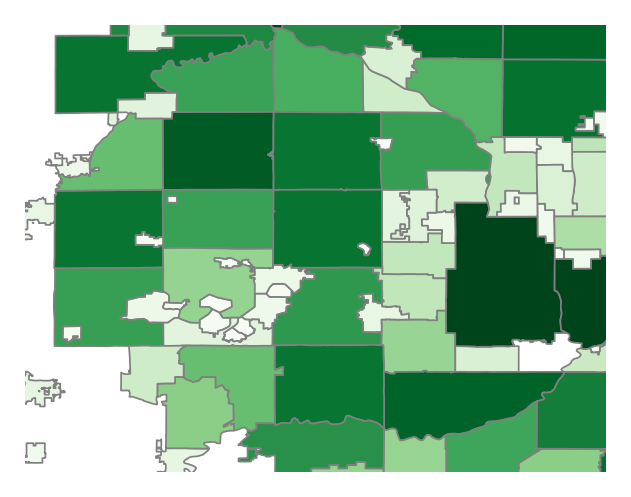

In [8]:
f, ax = plt.subplots(1, dpi=250, figsize=(3, 3))
ax.set_xlim([-93.8, -93.15])
ax.set_ylim([44.75, 45.25])
place.plot('ALAND', ax=ax, vmin=0, vmax=10e7, cmap='Greens', linewidth=0.5,edgecolor='grey')
plt.axis(False)

Since the tracts are not strictly corresponding to (although mostly resembling) city boundries, we need to map the tracts to cities roughly by intersection area. 

Accordingly, we use this mapping to output the geometries of the cities (our version of cities, boundries defined by their containing tracts).

In [9]:
# Join city geometries with tract geometries by intersection
place_tract = gp.sjoin(place[['NAME', 'geometry']], geo[['TRACTCE', 'geometry']])
# The above line will only keep the city geometries when merging. 
# So we merge the tract geometries back
place_tract = place_tract.rename(columns={'geometry':'place_geometry'})
place_tract = pd.merge(place_tract, geo[['TRACTCE', 'geometry']], on='TRACTCE')
place_tract = place_tract.rename(columns={'geometry':'tract_geometry'}).drop('index_right',axis=1)

In [10]:
# Now we have candidate mapping relationships, we examine the intersection area of each pair
place_tract['intersection_area'] = place_tract.\
            apply(lambda x: x['place_geometry'].intersection(x['tract_geometry']).area, axis=1)

place_tract['tract_area'] = place_tract['tract_geometry'].apply(lambda x: x.area)
place_tract['place_area'] = place_tract['place_geometry'].apply(lambda x: x.area)

place_tract['cover_in_tract'] = place_tract['intersection_area'] / place_tract['tract_area']
place_tract['cover_in_place'] = place_tract['intersection_area'] / place_tract['place_area']

In [11]:
# We exclude the pairs where the city only covers less than 20% of the tract area
place_tract = place_tract[place_tract['cover_in_tract']>0.2]

In [12]:
# As shown, we have 298 tracts, 3 of them have more than one city paired with them
place_tract.groupby('TRACTCE')['NAME'].count().sort_values()

TRACTCE
000101    1
026910    1
026909    1
026908    1
026907    1
         ..
023902    1
126200    1
027501    2
027400    2
027203    2
Name: NAME, Length: 298, dtype: int64

In [13]:
# We need to combine the cities that share one tracts
place_tract['new_city_name'] = place_tract.groupby('TRACTCE')['NAME'].transform(lambda x: '-'.join(x))

(-93.7964878, -93.1653342, 44.76223725, 45.26968374999999)

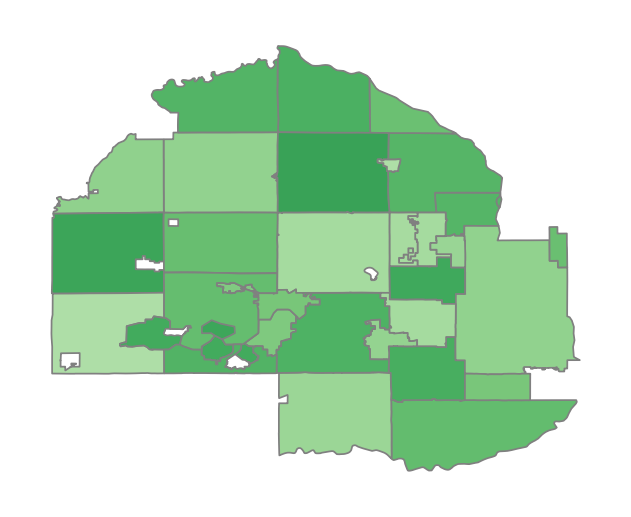

In [14]:
# Then we use the mapping from tracts to cities to generate the city geometries by our definition

place_geo = place_tract.groupby('new_city_name')['place_geometry'].\
            apply(shapely.ops.unary_union).reset_index()
place_geo.columns = ['city', 'geometry']
place_geo = gp.GeoDataFrame(place_geo, geometry='geometry')

f, ax = plt.subplots(1, dpi=250, figsize=(3, 3))
place_geo.plot(np.random.rand(len(place_geo)), ax=ax, vmin=-1, vmax=2, 
               cmap='Greens', linewidth=0.5,edgecolor='grey')
plt.axis(False)

In [15]:
# And then output the geometries into geojson file
place_geo.to_file('MN_053_City.geojson', 'GeoJSON')

## 3. Naming the Tracts

We take several steps to name the tracts:

#### First, if there is only one tract in a city, we name that tract with the city name

In [16]:
# Calculate tract number in each city, looking for one-on-one pairs
place_tract['tract_in_place'] = place_tract.groupby('new_city_name')['TRACTCE'].transform('count')
one_on_one_names = place_tract[place_tract['tract_in_place']==1][['TRACTCE', 'new_city_name']]
one_on_one_names['tract_name'] = one_on_one_names['new_city_name']

#### Second, for the rest of the tracts, we try to identify neighborhood names using Bing Maps API

In [17]:
for_nbh_names = place_tract[~place_tract['TRACTCE'].isin(one_on_one_names['TRACTCE'])]

In [18]:
# Defining the function to call the Bing Maps API
url = 'http://dev.virtualearth.net/REST/v1/Locations/{},{}?includeNeighborhood=1&key={}'
key = 'AnvVGVrf4XPDuuvWo83K-LWrBdrc8r6-e02o_EAm4cdGl4vYt9AEnxJ9P8nSG47D'

def call_nbh_api(lat, long):
    with urllib.request.urlopen(url.format(lat, long, key)) as r:
        res = json.loads(r.read())
    nbh = res['resourceSets'][0]['resources'][0]['address'].get('neighborhood')
    print(nbh)
    return nbh

In [43]:
# Using the API to query for neighborhood names using the centroids of the tracts
# The API is slow in my internet environment, so I didn't use pandas apply but used a for-loop
# If you use pandas apply and get a disconnection mid-way, you will need to run the whole thing again
res = []
for row in list(for_nbh_names.iterrows()):
    geo = row[1]['geometry'].centroid
    res.append(call_nbh_api(geo.y, geo.x))

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Crestview
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Parkwood Knolls
Presidents
None
None
None
None
Minnehaha
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Prospect Knolls
Centennial Lakes
None
None
Browndale
None
Rolling Green
Countryside
The Heights
West Bloomington
West Bloomington
Braemar Hills
Lake Edina
West Bloomington
West Bloomington
Brooklawns
None
East Bloomington
None
None
None
None
None
East Bloomington
East Bloomington
West Bloomington
West Bloomington
West Bloomington
None
None
East Bloomington
West Bloomington
West Bloomington
None
None
West Bloomington
East Bloomington
East Bloomington
East Bloomington
West Bloomington
West Bloomington
None
None
Eliot
Willow Park
Aquila
Oak Hill
Bronx Park
Lenox
Birchwood


#### If there is only one tract mapped to a neiborhood, we use the neighborhood name to name the tract.

In [197]:
for_nbh_names['nbh'] = res
for_nbh_names['nbh'] = for_nbh_names['nbh'].fillna('Other')
for_nbh_names['nbh_tract_num'] = for_nbh_names.groupby('nbh')['nbh'].transform('count')
use_nbh = for_nbh_names[for_nbh_names['nbh_tract_num']==1]
use_nbh['tract_name'] = use_nbh['new_city_name'] + ' - ' + use_nbh['nbh']

<ipython-input-197-f8a751377485>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_nbh_names['nbh'] = res
<ipython-input-197-f8a751377485>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_nbh_names['nbh'] = for_nbh_names['nbh'].fillna('Other')
<ipython-input-197-f8a751377485>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

#### Third, for the rest of the tracts, we use neighhood names (or "Other" if no neighborhood name returned from the API) and a ranking number by area to name the tract

In [198]:
rest = for_nbh_names[~for_nbh_names['TRACTCE'].isin(use_nbh['TRACTCE'])]
rest['rank'] = rest.groupby('nbh')['tract_area'].transform('rank').astype(int).astype(str)
rest['tract_name'] = rest['new_city_name'] + ' - ' + rest['nbh'] + ' - ' + rest['rank']

#### Lastly, combine the three results

In [205]:
tract_names = pd.concat([one_on_one_names[['TRACTCE', 'tract_name']], 
           use_nbh[['TRACTCE','tract_name']],
           rest[['TRACTCE','tract_name']]])

In [174]:
# Merge the files to get the mapping relationships and tract names for PBI visualizations
pd.merge(place_tract[['TRACTCE', 'new_city_name']].drop_duplicates(), tract_names, on='TRACTCE').to_csv('tract_profile.csv', index=None)